<a href="https://colab.research.google.com/github/XPONOKPATWP/nlp-project/blob/main/nlp_project_aivc24006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GlobalAveragePooling1D, Conv1D, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK resources (Run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
try:
    df = pd.read_csv("IMDB Dataset.csv")
except FileNotFoundError:
    print("Error: 'IMDB Dataset.csv' not found. Please ensure the file is in the correct directory or provide the correct path.")
    exit()

In [ ]:
jargon_abbreviations = {
    "oscar-worthy": "excellent",
    "box office hit": "successful movie",
    "cliffhanger": "abrupt ending",
    "prequel": "previous movie",
    "sequel": "following movie",
    "remake": "new version",
    "indie film": "independent film",
    "cgi": "computer generated imagery",
    "vfx": "visual effects",
    "rotfl": "rolling on the floor laughing",
    "lol": "laughing out loud",
    "imo": "in my opinion",
    "tbh": "to be honest",
}

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace=" ")
    words = text.split()
    words = [jargon_abbreviations.get(word, word) for word in words]
    text = " ".join(words)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

df['review'] = df['review'].apply(preprocess_text)
y = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')

X_train_seq, X_test_seq, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)


In [ ]:
classic_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB()
}

for name, model in classic_models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"Evaluation for {name}:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 30)

Training Logistic Regression...
Evaluation for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.8856
Precision: 0.8769111670214825
Recall: 0.8991863464973209
F1 Score: 0.8879090730942583
Confusion Matrix:
[[4325  636]
 [ 508 4531]]
------------------------------
Training Linear SVM...
Evaluation for Linear SVM:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy: 0.8792
Precision: 0.8731735827001753
Re

In [ ]:
embedding_dim = 100

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(MAX_VOCAB_SIZE, embedding_dim)(input_layer)
lstm_layer = LSTM(64)(embedding_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 166s 290ms/step - accuracy: 0.7376 - loss: 0.5108 - val_accuracy: 0.8658 - val_loss: 0.3199
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 196s 279ms/step - accuracy: 0.9054 - loss: 0.2495 - val_accuracy: 0.8735 - val_loss: 0.3089
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 163s 289ms/step - accuracy: 0.9342 - loss: 0.1803 - val_accuracy: 0.8625 - val_loss: 0.3434
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.9529 - loss: 0.1331 - val_accuracy: 0.8643 - val_loss: 0.4000
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 201s 284ms/step - accuracy: 0.9647 - loss: 0.1052 - val_accuracy: 0.8480 - val_loss: 0.4384


In [ ]:
y_pred_probs = lstm_model.predict(X_test_seq)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Evaluation for LSTM:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("-" * 30)


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step
Evaluation for LSTM:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy: 0.8808
Precision: 0.8797630799605133
Recall: 0.884302440960508
F1 Score: 0.8820269200316706
Confusion Matrix:
[[4352  609]
 [ 583 4456]]
------------------------------


In [ ]:
def residual_block(x, filters, kernel_size, dilation_rate):
    residual = x
    x = Conv1D(filters, kernel_size, padding='same', activation='relu', dilation_rate=dilation_rate)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters, kernel_size, padding='same', activation='relu', dilation_rate=dilation_rate)(x)
    x = Dropout(0.2)(x)
    if x.shape[-1] != residual.shape[-1]:
        residual = Conv1D(filters, 1, padding='same')(residual)
    return add([x, residual])

embedding_dim = 100
filters = 64
kernel_size = 3
dilation_rates = [1, 2, 4, 8]

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(MAX_VOCAB_SIZE, embedding_dim, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

x = embedding_layer
for dilation_rate in dilation_rates:
    x = residual_block(x, filters, kernel_size, dilation_rate)

x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

tcn_model = Model(inputs=input_layer, outputs=output_layer) #changed to tcn_model
optimizer = Adam(learning_rate=0.001)
tcn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #changed to tcn_model
tcn_model.summary()

tcn_model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.1) #changed to tcn_model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 200, 100)       │      1,000,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 64)        │         19,264 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 64)        │         12,352 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 64)        │          6,464 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 200, 64)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 200, 64)        │         12,352 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 200, 64)        │         12,352 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 200, 64)        │              0 │ dropout_4[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 200, 64)        │         12,352 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 200, 64)        │         12,352 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 200, 64)        │              0 │ dropout_6[0][0],       │
│                      

 Total params: 1,116,417 (4.26 MB)

 Trainable params: 1,116,417 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 239s 410ms/step - accuracy: 0.7052 - loss: 0.5292 - val_accuracy: 0.8788 - val_loss: 0.2800
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 225s 400ms/step - accuracy: 0.9151 - loss: 0.2258 - val_accuracy: 0.8825 - val_loss: 0.2810
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 298s 464ms/step - accuracy: 0.9420 - loss: 0.1618 - val_accuracy: 0.8783 - val_loss: 0.3265
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 219s 389ms/step - accuracy: 0.9597 - loss: 0.1182 - val_accuracy: 0.8813 - val_loss: 0.3559
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 223s 395ms/step - accuracy: 0.9734 - loss: 0.0764 - val_accuracy: 0.8690 - val_loss: 0.4900


In [ ]:
y_pred_probs = tcn_model.predict(X_test_seq) #changed to tcn_model
y_pred = (y_pred_probs > 0.5).astype(int)

print("Evaluation for TCN:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("-" * 30)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step
Evaluation for TCN:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4961
           1       0.90      0.83      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy: 0.8704
Precision: 0.9011789924973205
Recall: 0.8342925183568168
F1 Score: 0.8664468260511129
Confusion Matrix:
[[4500  461]
 [ 835 4204]]
------------------------------


In [ ]:
def predict_sentiment_tfidf(text, model, vectorizer):
    processed_text = preprocess_text(text)
    text_vectorized = vectorizer.transform([processed_text])
    prediction = model.predict(text_vectorized)[0]
    return "Positive" if prediction == 1 else "Negative"

def predict_sentiment_seq(text, model, tokenizer):
    processed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')
    prediction = (model.predict(padded_sequence) > 0.5).astype(int)[0][0]
    return "Positive" if prediction == 1 else "Negative"

# Example usage (using Logistic Regression, LSTM, and TCN)
new_review = "This movie was great it defently needs an oscar"
print(f"Prediction for: '{new_review}' using Logistic Regression is: {predict_sentiment_tfidf(new_review, classic_models['Logistic Regression'], tfidf_vectorizer)}")
print(f"Prediction for: '{new_review}' using LSTM is: {predict_sentiment_seq(new_review, lstm_model, tokenizer)}")
print(f"Prediction for: '{new_review}' using TCN is: {predict_sentiment_seq(new_review, tcn_model, tokenizer)}")

new_review = "The concept was intresting but the actors and the practical effects where awful"
print(f"Prediction for: '{new_review}' using Logistic Regression is: {predict_sentiment_tfidf(new_review, classic_models['Logistic Regression'], tfidf_vectorizer)}")
print(f"Prediction for: '{new_review}' using LSTM is: {predict_sentiment_seq(new_review, lstm_model, tokenizer)}")
print(f"Prediction for: '{new_review}' using TCN is: {predict_sentiment_seq(new_review, tcn_model, tokenizer)}")

Prediction for: 'This movie was great it defently needs an oscar' using Logistic Regression is: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction for: 'This movie was great it defently needs an oscar' using LSTM is: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for: 'This movie was great it defently needs an oscar' using TCN is: Positive
Prediction for: 'The concept was intresting but the actors and the practical effects where awful' using Logistic Regression is: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction for: 'The concept was intresting but the actors and the practical effects where awful' using LSTM is: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for: 'The concept was intresting but the actors and the practical effects where awful' using TCN is: Negative


Performance Metrics Table:
              Model  Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.8856     0.8769  0.8992    0.8879
         Linear SVM    0.8792     0.8732  0.8895    0.8812
        Naive Bayes    0.8494     0.8478  0.8545    0.8512
               LSTM    0.8808     0.8798  0.8843    0.8820
                TCN    0.8704     0.9012  0.8343    0.8664




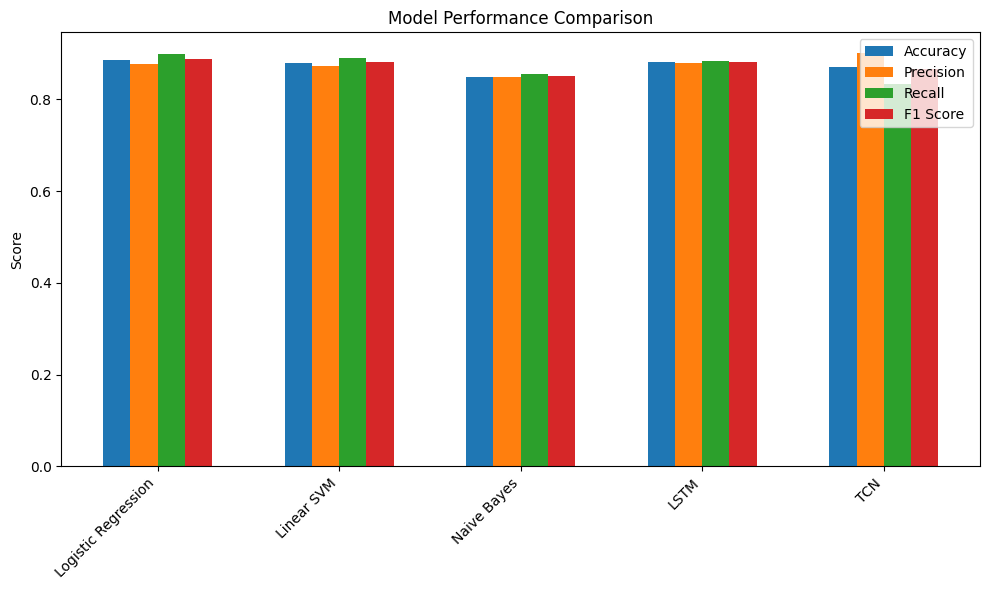

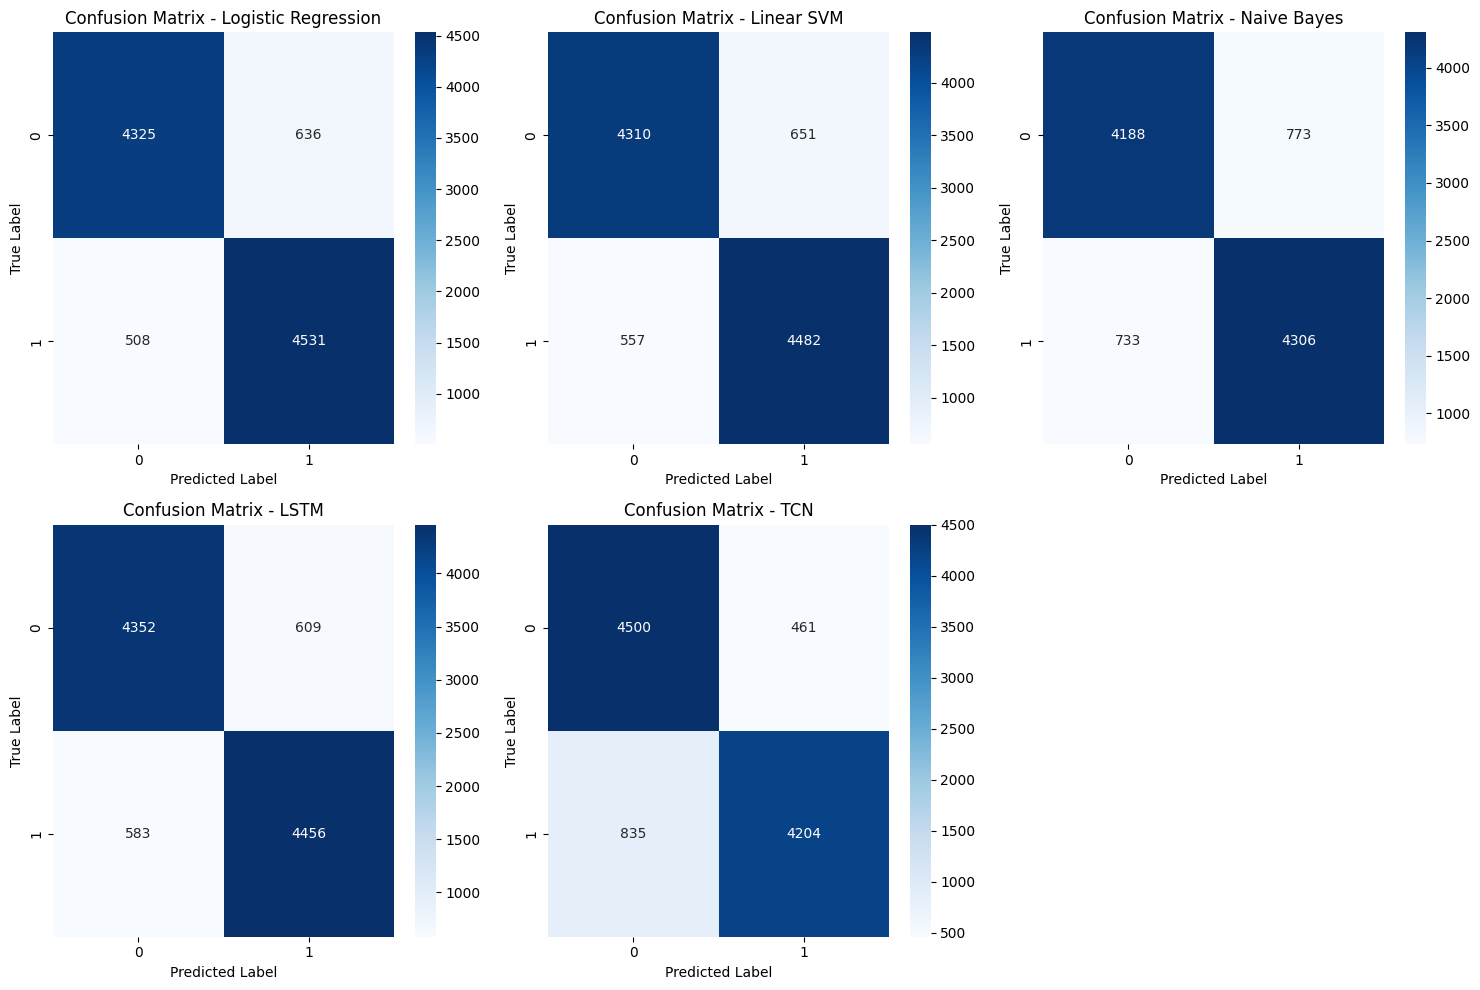

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data from your provided evaluations
data = {
    "Model": ["Logistic Regression", "Linear SVM", "Naive Bayes", "LSTM", "TCN"],
    "Accuracy": [0.8856, 0.8792, 0.8494, 0.8808, 0.8704],
    "Precision": [0.8769, 0.8732, 0.8478, 0.8798, 0.9012],
    "Recall": [0.8992, 0.8895, 0.8545, 0.8843, 0.8343],
    "F1 Score": [0.8879, 0.8812, 0.8512, 0.8820, 0.8664],
    "Confusion Matrix": [
        [[4325, 636], [508, 4531]],
        [[4310, 651], [557, 4482]],
        [[4188, 773], [733, 4306]],
        [[4352, 609], [583, 4456]],
        [[4500, 461], [835, 4204]],
    ],
}

df = pd.DataFrame(data)

# 1. Table Representation
print("Performance Metrics Table:")
print(df[["Model", "Accuracy", "Precision", "Recall", "F1 Score"]].to_string(index=False))
print("\n")

# 2. Bar Chart for Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
plt.figure(figsize=(10, 6))
width = 0.15  # Width of each bar

x = range(len(df))
for i, metric in enumerate(metrics):
    plt.bar([j + i*width for j in x], df[metric], width, label=metric)

plt.xticks([j + 1.5*width for j in x], df["Model"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Heatmaps for Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust layout for 5 plots
axes = axes.ravel()  # Flatten the axes array

for i, model in enumerate(df["Model"]):
    cm = df["Confusion Matrix"][i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i],
                xticklabels=[0, 1], yticklabels=[0, 1])
    axes[i].set_title(f"Confusion Matrix - {model}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

# Remove extra subplot if only 5 models
if len(df["Model"]) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import emoji

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from torch.cuda.amp import autocast, GradScaler

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the dataset
df = pd.read_csv("IMDB Dataset.csv")

# Preprocessing
jargon_abbreviations = {
    "oscar-worthy": "excellent",
    "box office hit": "successful movie",
    "cliffhanger": "abrupt ending",
    "prequel": "previous movie",
    "sequel": "following movie",
    "remake": "new version",
    "indie film": "independent film",
    "cgi": "computer generated imagery",
    "vfx": "visual effects",
    "rotfl": "rolling on the floor laughing",
    "lol": "laughing out loud",
    "imo": "in my opinion",
    "tbh": "to be honest",
}

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace=" ")
    words = [jargon_abbreviations.get(word, word) for word in text.split()]
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['review'] = df['review'].apply(preprocess_text)

# Limit data to 2500 samples
df_limited = df.sample(2500, random_state=42).reset_index(drop=True) # Reset index after sampling
y_limited = df_limited['sentiment'].map({'positive': 1, 'negative': 0})

# Tokenization
batch_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_data = batch_tokenizer.batch_encode_plus(
    df_limited['review'].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

input_ids, attention_masks = encoded_data['input_ids'], encoded_data['attention_mask']
labels = torch.tensor(y_limited.values)

X_train_ids, X_test_ids, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
X_train_masks, X_test_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)

batch_size = 32 # Reduced batch size to fit in memory more easily with smaller dataset
train_dataset = TensorDataset(X_train_ids, X_train_masks, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_ids, X_test_masks, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
scaler = GradScaler()
epochs = 3

# Training with Mixed Precision
for epoch in range(epochs):
    model.train()
    for i, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

# Evaluation
model.eval()
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        y_pred.extend(predictions.cpu().numpy())

y_true = y_test.cpu().numpy()
print("Evaluation:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Using device: cpu


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warn

Evaluation:
Accuracy: 0.84
Precision: 0.871900826446281
Recall: 0.8115384615384615
F1 Score: 0.8406374501992032
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       240
           1       0.87      0.81      0.84       260

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500

